In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import evaluate

/home/salman/anaconda3/envs/GPU/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-06-23 21:34:20.282079: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-23 21:34:20.289477: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750685660.297273  117103 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750685660.299553  117103 cuda_blas.cc:1407

In [6]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
# ---------------- Dataset ----------------
class TrafficSignDataset(Dataset):
    def __init__(self, data):
        self.data = data
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        img, label = self.data[idx]
        return img, label

with open("train_tensor_data.pkl", "rb") as f:
    train_data = pickle.load(f)
with open("test_tensor_data.pkl", "rb") as f:
    test_data = pickle.load(f)

# Wrap as Dataset
full_train_dataset = TrafficSignDataset(train_data)
test_dataset = TrafficSignDataset(test_data)

# Split train/val
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [8]:
# ---------------- CNN Model ----------------
class ScratchCNN(nn.Module):
    def __init__(self):
        super(ScratchCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 23)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 112x112
        x = self.pool(F.relu(self.conv2(x)))  # 56x56
        x = self.pool(F.relu(self.conv3(x)))  # 28x28
        x = x.view(x.size(0), -1)             # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [9]:
# ---------------- Train Function ----------------
def train_model(model, epochs=10, lr=1e-3):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_train_acc = 0
    best_val_acc = 0
    train_accs, val_accs = [], []

    for epoch in range(epochs):
        model.train()
        correct, total = 0, 0
        for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            preds = model(x)
            loss = criterion(preds, y)
            loss.backward()
            optimizer.step()

            correct += (preds.argmax(1) == y).sum().item()
            total += y.size(0)
        acc = correct / total
        train_accs.append(acc)
        best_train_acc = max(best_train_acc, acc)

        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                preds = model(x)
                correct += (preds.argmax(1) == y).sum().item()
                total += y.size(0)
        acc = correct / total
        val_accs.append(acc)
        best_val_acc = max(best_val_acc, acc)

    return train_accs, val_accs, best_train_acc, best_val_acc

In [14]:
# ---------------- Train & Test ----------------
model = ScratchCNN().to(device)
train_accs, val_accs, best_train, best_val = train_model(model, epochs=20, lr=1e-3)

# Evaluate on test set using evaluate library
accuracy_metric = evaluate.load("accuracy")
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
	for x, y in test_loader:
		x = x.to(device)
		preds = model(x)
		all_preds.extend(preds.argmax(1).cpu().numpy())
		all_labels.extend(y.cpu().numpy())
test_acc = accuracy_metric.compute(predictions=all_preds, references=all_labels)["accuracy"]

Epoch 20/20: 100%|██████████| 98/98 [00:04<00:00, 23.79it/s]


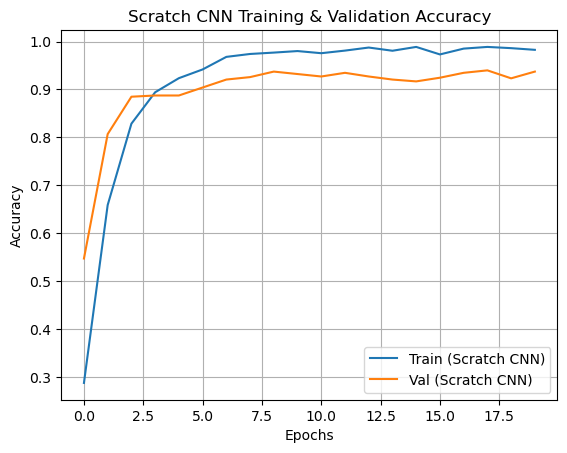

In [15]:
# ---------------- Plot ----------------
plt.plot(train_accs, label="Train (Scratch CNN)")
plt.plot(val_accs, label="Val (Scratch CNN)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Scratch CNN Training & Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

In [16]:
# ---------------- Report ----------------
print(f"Best Train Accuracy: {best_train:.4f}")
print(f"Best Val Accuracy:   {best_val:.4f}")
print(f"Test Accuracy:       {test_acc:.4f}")

Best Train Accuracy: 0.9888
Best Val Accuracy:   0.9399
Test Accuracy:       0.9442
